# R-CNN Implementation

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import cv2
import torchvision

/home/intern2/Projects/rcnn/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset preparing

Fine-tuning : VOC 2012 train set

SVM         : VOC 2012 trainval set

Test        : VOC 2007 trainval set

In [4]:
train_data_finetuning = VOCDetection(root='data/finetuning',
                                     year='2012',
                                     image_set='train',
                                     download=False)

train_data_SVM = VOCDetection(root='data/SVM',
                              year='2012',
                              image_set='trainval',
                              download=False)

test_data = VOCDetection(root='data/test',
                         year='2007',
                         image_set='trainval',
                         download=False)

## Region Proposals

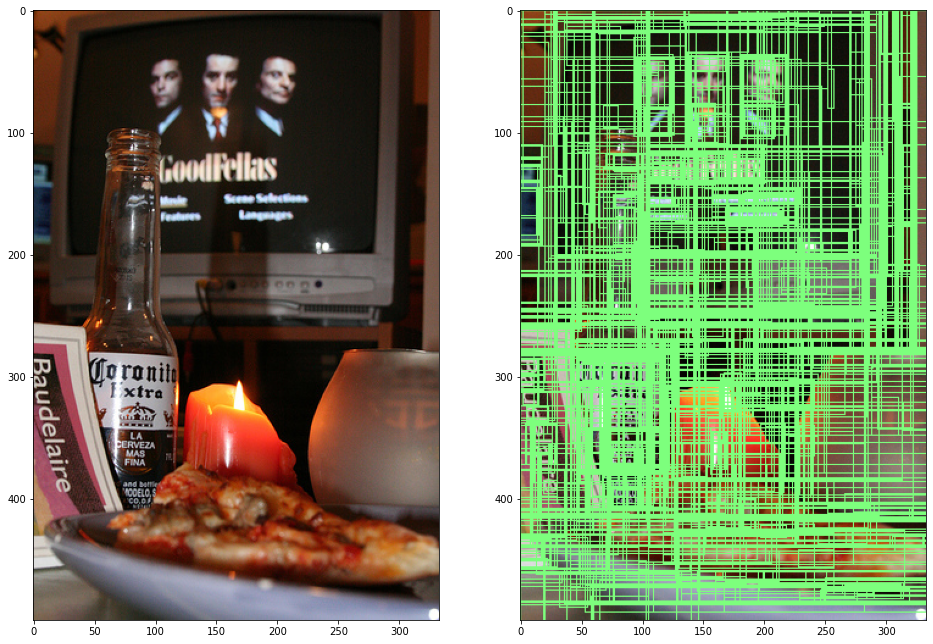

In [5]:
src, trg = train_data_finetuning[3]

src = np.array(src)
fig = plt.figure(figsize=(16,16))

# OpenCV는 BGR 색공간 기준, 기존 data는 RGB 환경
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#################################################################
output = src.copy()
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)

ss.setBaseImage(src)
ss.switchToSelectiveSearchFast()
rois = ss.process()

color = (125, 255, 125)
for roi in rois:
    x, y, w, h = roi
    cv2.rectangle(output, (x,y), (x+w,y+h), color, 1)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(output)
plt.show()
#################################################################

In [6]:
def region_proposal(ss, src):
    """_summary_

    Args:
        ss (Module): SelectiveSearch module
        src (2D ndarray, RGB): input image, RGB 2D ndarray

    Returns:
        rois (2D ndarray): (N x 4), N is num_rois and 4 means coordinates of roi (x, y, width, height)
    """
    src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)
    ss.setBaseImage(src)
    ss.switchToSelectiveSearchFast()
    rois = ss.process()
    return rois

# Finetuning Labeling

In [7]:
def ft_labeling(root, dataset, num_samples, threshold, classes):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    columns = ['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    
    pos_csv = pd.DataFrame(columns=columns)
    neg_csv = pd.DataFrame(columns=columns)
    
    for i, (src, trg) in enumerate(dataset):
        if i >= num_samples:
            break
        
        filename = []
        gt_label = []
        gt_rois = []   
        for object in trg['annotation']['object']:
            gt_label.append(classes[object['name']])
            gt_rois.append(tuple(map(int, tuple(object['bndbox'].values()))))

        src = np.array(src)
        rois = torch.tensor(region_proposal(ss, src))
        # SS에 의해 구해진 rois coord는 x,y,w,h임.
        # xmin, ymin, xmax, ymax로 변경
        rois[:,2].add_(rois[:,0])
        rois[:,3].add_(rois[:,1])
        gt_rois = torch.tensor(gt_rois)
        gt_label = torch.tensor(gt_label)
        
        ious = torchvision.ops.box_iou(rois, gt_rois)

        mask = (ious > threshold)
        
        positive_indices = mask.nonzero()
        negative_indices = torch.sum(mask, dim=1).sub_(1).nonzero()

        positive_rois = rois[positive_indices[:,0]]
        negative_rois = rois[negative_indices[:,0]]
        
        positive_labels = gt_label[positive_indices[:,1]].unsqueeze(1)
        negative_labels = torch.zeros(negative_indices.shape[0]).unsqueeze(1)
        
        pos_tmp = pd.DataFrame(torch.cat((positive_labels, positive_rois), dim=1).int().numpy(), columns=columns[1:])
        neg_tmp = pd.DataFrame(torch.cat((negative_labels, negative_rois), dim=1).int().numpy(), columns=columns[1:])
        filename = trg['annotation']['filename']
        pos_tmp.insert(0, "filename", filename)
        neg_tmp.insert(0, "filename", filename)
        
        pos_csv = pd.concat([pos_csv, pos_tmp], ignore_index=True)
        neg_csv = pd.concat([neg_csv, neg_tmp], ignore_index=True)
        
        pos_csv.to_csv(os.path.join(root, 'ft_positive.csv'), mode='w')
        neg_csv.to_csv(os.path.join(root, 'ft_negative.csv'), mode='w')

# FineTuning Dataset

In [8]:
from PIL import Image

class FineTuningDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx, 3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        trg = self.csv_file.iloc[idx, 2]

        if self.transform:
            src = self.transform(img)
        
        return src, trg  

# FineTuning

In [9]:
classes_str = {
    'background':0,
    'aeroplane':1,
    'bicycle':2,
    'bird':3,
    'boat':4,
    'bottle':5,
    'bus':6,
    'car':7,
    'cat':8,
    'chair':9,
    'cow':10,
    'diningtable':11,
    'dog':12,
    'horse':13,
    'motorbike':14,
    'person':15,
    'pottedplant':16,
    'sheep':17,
    'sofa':18,
    'train':19,
    'tvmonitor':20
}
classes_int = dict((y,x) for x,y in classes_str.items())

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

root = 'data/finetuning/VOCdevkit/VOC2012/JPEGImages'

In [10]:
# ft_labeling(root=root, dataset=train_data_finetuning, num_samples=500, threshold=0.5, classes=classes_str)

In [19]:
root = 'data/finetuning/VOCdevkit/VOC2012/JPEGImages'

num_epochs = 1
batch_size = 96
positive_size = batch_size // 4
negative_size = batch_size // 4 * 3

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(classes_str))
model = model.to(device)

ft_positive_dataset = FineTuningDataset(root, 'ft_positive.csv', classes_int, transforms.ToTensor())
ft_negative_dataset = FineTuningDataset(root, 'ft_negative.csv', classes_int, transforms.ToTensor())

ft_positive_dataloader = DataLoader(ft_positive_dataset, positive_size, shuffle=True, num_workers=1, drop_last=True)
ft_negative_dataloader = DataLoader(ft_negative_dataset, negative_size, shuffle=True, num_workers=1, drop_last=True)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(ft_positive_dataloader, ft_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device=device).float()
        trg = torch.cat((pos_trg, neg_trg)).to(device=device).long()

        ft_optimizer.zero_grad()

        out = model(src)
        loss = ft_criterion(out, trg)

        if batch_idx % 40 == 0:

            losses.append(loss.item())
            print(f"Batch: {batch_idx}, Loss:{loss.item()}")
        loss.backward()
        ft_optimizer.step()

Epoch 0/0
----------
Batch: 0, Loss:3.239790678024292
Batch: 40, Loss:0.9284492135047913
Batch: 80, Loss:0.5496950745582581
Batch: 120, Loss:0.4416068494319916
Batch: 160, Loss:0.36469605565071106
Batch: 200, Loss:0.368770956993103
Batch: 240, Loss:0.29557719826698303
Batch: 280, Loss:0.18309231102466583
Batch: 320, Loss:0.2677881121635437
Batch: 360, Loss:0.35095903277397156
Batch: 400, Loss:0.38575419783592224
Batch: 440, Loss:0.2744695544242859
Batch: 480, Loss:0.19663815200328827
Batch: 520, Loss:0.26042336225509644
Batch: 560, Loss:0.2743820250034332
Batch: 600, Loss:0.22719933092594147
Batch: 640, Loss:0.254665732383728
Batch: 680, Loss:0.20388899743556976
Batch: 720, Loss:0.19618408381938934
Batch: 760, Loss:0.15643103420734406
Batch: 800, Loss:0.058712542057037354
Batch: 840, Loss:0.2238134741783142
Batch: 880, Loss:0.17288388311862946
Batch: 920, Loss:0.2063928097486496
Batch: 960, Loss:0.14978043735027313
Batch: 1000, Loss:0.15224291384220123
Batch: 1040, Loss:0.1557369530200

In [21]:
torch.save(model.state_dict(), 'ft_model_state_dict')

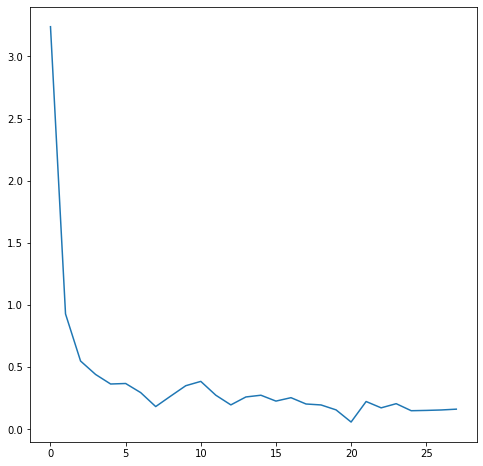

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(losses)
plt.show()

# SVM Labeling

In [11]:
def svm_labeling(root, dataset, num_samples, threshold, classes):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    columns = ['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    
    pos_csv = pd.DataFrame(columns=columns)
    neg_csv = pd.DataFrame(columns=columns)
    
    for i, (src, trg) in enumerate(dataset):
        if i >= num_samples:
            break
        
        filename = []
        gt_label = []
        gt_rois = []   
        for object in trg['annotation']['object']:
            gt_label.append(classes[object['name']])
            gt_rois.append(tuple(map(int, tuple(object['bndbox'].values()))))

        src = np.array(src)
        rois = torch.tensor(region_proposal(ss, src))
        # SS에 의해 구해진 rois coord는 x,y,w,h임.
        # xmin, ymin, xmax, ymax로 변경
        rois[:,2].add_(rois[:,0])
        rois[:,3].add_(rois[:,1])
        gt_rois = torch.tensor(gt_rois)
        gt_label = torch.tensor(gt_label)
        
        ious = torchvision.ops.box_iou(rois, gt_rois)

        mask = (ious > threshold)
        
        negative_indices = torch.sum(mask, dim=1).sub_(1).nonzero()

        positive_rois = gt_rois
        negative_rois = rois[negative_indices[:,0]]
        
        positive_labels = gt_label.unsqueeze(1)
        negative_labels = torch.zeros(negative_indices.shape[0]).unsqueeze(1)
        
        pos_tmp = pd.DataFrame(torch.cat((positive_labels, positive_rois), dim=1).int().numpy(), columns=columns[1:])
        neg_tmp = pd.DataFrame(torch.cat((negative_labels, negative_rois), dim=1).int().numpy(), columns=columns[1:])
        filename = trg['annotation']['filename']
        pos_tmp.insert(0, "filename", filename)
        neg_tmp.insert(0, "filename", filename)
        
        pos_csv = pd.concat([pos_csv, pos_tmp], ignore_index=True)
        neg_csv = pd.concat([neg_csv, neg_tmp], ignore_index=True)
        
        pos_csv.to_csv(os.path.join(root, 'svm_positive.csv'), mode='w')
        neg_csv.to_csv(os.path.join(root, 'svm_negative.csv'), mode='w')

# SVM Dataset

In [12]:
from PIL import Image

class SVMDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx,3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        
        trg = self.csv_file.iloc[idx, 2]

        if self.transform:
            src = self.transform(img)
        
        return src, trg

# SVM Training

In [104]:
svm_root = 'data/SVM/VOCdevkit/VOC2012/JPEGImages'

In [40]:
# svm_labeling(root=root, dataset=train_data_SVM, num_samples=1500, threshold=0.3, classes=classes_str)

In [52]:
batch_size = 256
positive_size = batch_size // 2
negative_size = batch_size // 2

svm_positive_dataset = SVMDataset(svm_root, 'svm_positive.csv', classes_int, transforms.ToTensor())
svm_negative_dataset = SVMDataset(svm_root, 'svm_negative.csv', classes_int, transforms.ToTensor())

svm_positive_dataloader = DataLoader(svm_positive_dataset, positive_size, shuffle=True, num_workers=2, drop_last=True)
svm_negative_dataloader = DataLoader(svm_negative_dataset, negative_size, shuffle=True, num_workers=2, drop_last=True)

In [105]:
positive_svm = pd.read_csv(os.path.join(svm_root, 'svm_positive.csv'))

<BarContainer object of 20 artists>

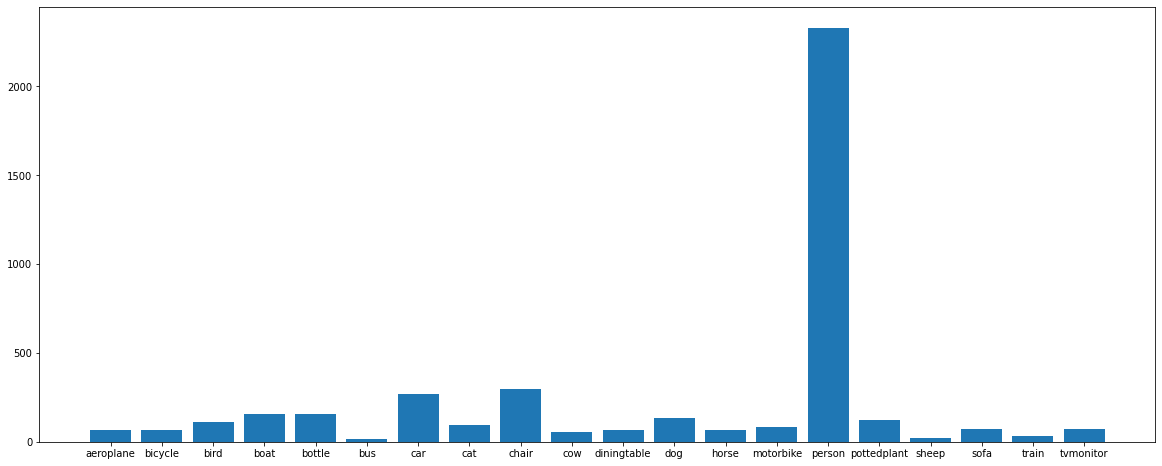

In [115]:
svm_positive_label = np.array(positive_svm['label'])

unique, counts = np.unique(svm_positive_label, return_counts=True)
svm_label_frequency = {}
for label, cnt in zip(unique, counts):
    svm_label_frequency[classes_int[label]] = cnt
keys = svm_label_frequency.keys()
values = svm_label_frequency.values()

plt.figure(figsize=(20,8))
plt.bar(keys, values)

In [56]:
from tqdm import tqdm

lr = 1e-3
num_epochs = 4

svm_losses = []

model = models.mobilenet_v2().to(device)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.last_channel, len(classes_str)).to(device)
model.load_state_dict(torch.load('ft_model_state_dict'))

svm_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
svm_criterion = nn.MultiMarginLoss(reduction='sum')

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(svm_positive_dataloader, svm_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device).long()

        svm_optimizer.zero_grad()

        output = model(src)

        svm_loss = svm_criterion(output, trg)
        
        if batch_idx % 5 == 0:
            svm_losses.append(svm_loss.item())
            print(f"Batch: {batch_idx}, Loss:{svm_loss.item()}")
        svm_loss.backward()
        svm_optimizer.step()

Epoch 0/3
----------
Batch: 0, Loss:10.805011749267578
Batch: 5, Loss:4.349612236022949
Batch: 10, Loss:7.945621490478516
Batch: 15, Loss:10.551582336425781
Batch: 20, Loss:5.161674499511719
Batch: 25, Loss:7.137863636016846
Batch: 30, Loss:3.8470101356506348
Batch: 35, Loss:6.6644606590271
Batch: 40, Loss:4.387580871582031
Batch: 45, Loss:6.443318843841553
Batch: 50, Loss:6.381875038146973
Batch: 55, Loss:4.620797157287598
Batch: 60, Loss:4.465739727020264
Batch: 65, Loss:6.046892166137695
Epoch 1/3
----------
Batch: 0, Loss:5.115004062652588
Batch: 5, Loss:2.9992876052856445
Batch: 10, Loss:4.264848709106445
Batch: 15, Loss:3.0437045097351074
Batch: 20, Loss:3.466308116912842
Batch: 25, Loss:3.4516043663024902
Batch: 30, Loss:5.953245162963867
Batch: 35, Loss:2.8787975311279297
Batch: 40, Loss:5.903970241546631
Batch: 45, Loss:5.089301109313965
Batch: 50, Loss:5.6600494384765625
Batch: 55, Loss:2.5571069717407227
Batch: 60, Loss:3.712007522583008
Batch: 65, Loss:5.225372314453125
Epo

In [66]:
num_epochs = 100

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(svm_positive_dataloader, svm_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device).long()

        svm_optimizer.zero_grad()

        output = model(src)

        svm_loss = svm_criterion(output, trg)

        if batch_idx % 5 == 0:
            svm_losses.append(svm_loss.item())
            print(f"Batch: {batch_idx}, Loss:{svm_loss.item()}")
        svm_loss.backward()
        svm_optimizer.step()

Epoch 0/99
----------
Batch: 0, Loss:1.851109266281128
Batch: 5, Loss:2.3341846466064453
Batch: 10, Loss:1.2362265586853027
Batch: 15, Loss:1.3353720903396606
Batch: 20, Loss:1.5787835121154785
Batch: 25, Loss:1.0395417213439941
Batch: 30, Loss:1.346952199935913
Batch: 35, Loss:1.434859275817871
Batch: 40, Loss:1.414951205253601
Batch: 45, Loss:1.183032751083374
Batch: 50, Loss:2.030466318130493
Batch: 55, Loss:1.093630313873291
Batch: 60, Loss:1.6052470207214355
Batch: 65, Loss:1.4674705266952515
Epoch 1/99
----------
Batch: 0, Loss:0.7550255060195923
Batch: 5, Loss:1.2919032573699951
Batch: 10, Loss:1.631112813949585
Batch: 15, Loss:1.2637817859649658
Batch: 20, Loss:1.2656335830688477
Batch: 25, Loss:1.4176663160324097
Batch: 30, Loss:1.3713533878326416
Batch: 35, Loss:0.9584715366363525
Batch: 40, Loss:1.2925384044647217
Batch: 45, Loss:1.3841688632965088
Batch: 50, Loss:1.7945168018341064
Batch: 55, Loss:1.9960086345672607
Batch: 60, Loss:1.0207984447479248
Batch: 65, Loss:1.22440

In [84]:
torch.save(model.state_dict(), 'svm_model_state_dict')

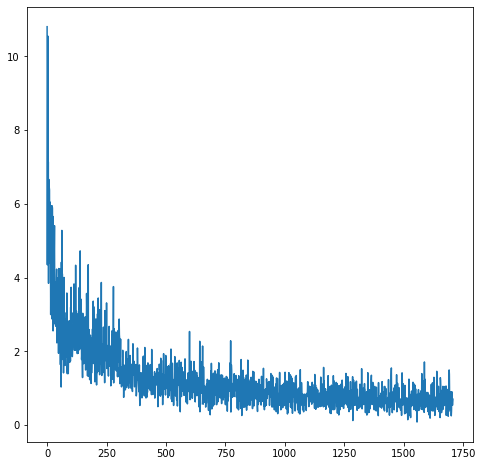

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(svm_losses)
plt.show()

# Evaluation without using BBox Regressor

In [124]:
from tqdm import tqdm

src, trg = test_data[8]

model.eval()

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

src = np.array(src)
rois = torch.tensor(region_proposal(ss, src))
rois[:,2].add_(rois[:,0])
rois[:,3].add_(rois[:,1])

root = 'data/test/VOCdevkit/VOC2007/JPEGImages'

filename = trg['annotation']['filename']

transform = transforms.ToTensor()

result = src.copy()
bbox = []
bbox_score = []
bbox_label = []

for roi in tqdm(rois):
    x1,y1,x2,y2 = roi
    if (x2-x1)*(y2-y1) > 500:
        roi = roi.numpy()
        input = Image.open(os.path.join(root, filename)).crop(roi).convert('RGB').resize((224, 224), Image.NEAREST)
        input = transform(input)
        input = input.unsqueeze(0).to(device)
        output = model(input)
        label = torch.argmax(output).item()
        score = (output[0,label]).item()

        if label != 0:
            bbox.append(roi)
            bbox_score.append(score)
            bbox_label.append(label)

100%|██████████| 2166/2166 [00:15<00:00, 142.85it/s]


In [125]:
copy_bbox = torch.Tensor(np.array(bbox))
copy_bbox_score = torch.Tensor(np.array(bbox_score))
copy_bbox_label = torch.Tensor(np.array(bbox_label))

In [126]:
res_bbox = torchvision.ops.nms(copy_bbox, copy_bbox_score, 0.1)
res_bbox.shape

torch.Size([7])

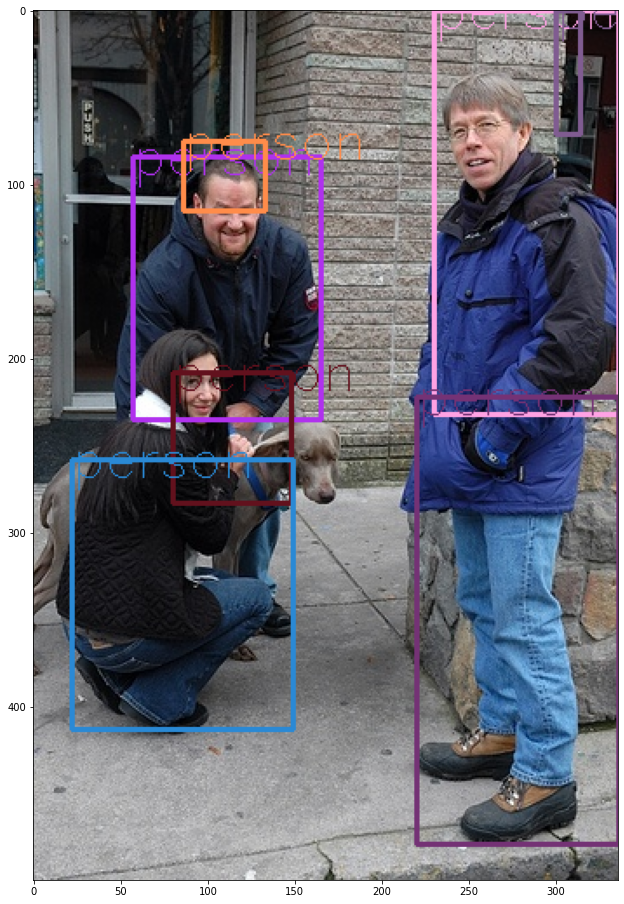

In [127]:
result = src.copy()
for bbox, label in zip(copy_bbox[res_bbox], copy_bbox_label[res_bbox]):
    color = list(np.random.random(size=3) * 256)
    x1, y1, x2, y2 = bbox.int().tolist()
    cv2.rectangle(result, (x1,y1), (x2,y2), color, 2)
    cv2.putText(result, classes_int[label.item()], (x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=color, thickness=1)
plt.figure(figsize=(16,16))
plt.imshow(result)
plt.show()   